In [1]:
car_dataset = '/content/drive/MyDrive/carDataset.zip'

In [2]:
!unzip "/content/drive/My Drive/carDataset.zip"

Archive:  /content/drive/My Drive/carDataset.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annota

#SOBEL EDGE DETECTION

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io
import os

In [115]:
def conv(image, kernel):

    Height, Width = image.shape
    height_k, weight_k = kernel.shape
    output = np.zeros((Height, Width))


    pad1 = height_k // 2
    pad2 = weight_k // 2
    pad3 = ((pad1,pad1),(pad2,pad2))
    padd = np.pad(image, pad3, mode='edge')


    for m in range(Height):
        for n in range(Width):
            output[m,n] = np.sum(padd[m : m + height_k, n : n + weight_k] * kernel)


    return output

In [116]:
def sobel_x(img):
   x_deriv = 0.5 * np.array([-1,0,1])
   x_deriv.shape = 1, 3
   output = conv(img, x_deriv)

   return output

In [117]:
def sobel_y(img):
  y_deriv = 0.5 * np.array([-1, 0, 1])
  y_deriv.shape = 3, 1
  output = conv(img, y_deriv)

  return output

In [118]:
def gradient_sobel(img):
  G = np.zeros(img.shape)

  Gx = sobel_x(img)
  Gy = sobel_y(img)
  G = np.sqrt(np.power(Gx, 2) + np.power(Gy, 2))

  return G

In [119]:
def sobel_edge(image):
    return gradient_sobel(image)

In [120]:
image_folder = '/content/images/'
images = os.listdir(image_folder)
images = sorted(os.listdir(image_folder))

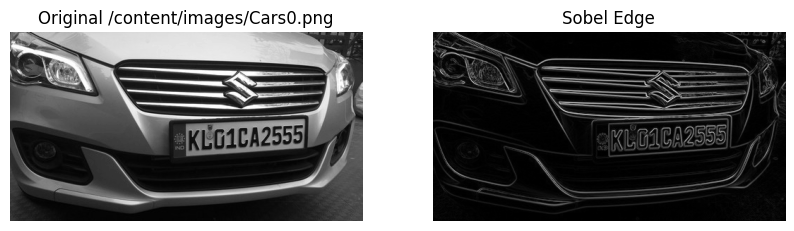

In [121]:

img_path = "/content/images/Cars0.png"

img = io.imread(img_path, as_gray=True)
sobel = sobel_edge(img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f'Original {img_path}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sobel, cmap='gray')
plt.title('Sobel Edge')
plt.axis('off')

plt.show()


#CANNY EDGE DETECTİON

In [122]:
def partial_x(img):
    filter = np.array([-0.5,0,0.5]).reshape((1, 3))
    output = conv(np.array(img),filter)

    return output

def partial_y(img):
    filter = np.array([-0.5, 0, 0.5]).reshape((3, 1))
    output = conv(np.array(img), filter)

    return output

In [123]:
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))

    k = (size - 1) / 2
    coefficient = 1 / (2 * np.pi * sigma**2)
    for i in range(size):
        for j in range(size):
            exponent = -( (i - k)**2 + (j - k)**2 ) / (2 * sigma**2)
            kernel[i, j] = coefficient * np.exp(exponent)

    return kernel

In [124]:
def gradient_canny(img):
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    Gx = partial_x(img)
    Gy = partial_y(img)
    G = np.sqrt(np.power(Gx, 2) + np.power(Gy, 2))
    theta = (np.arctan2(Gy, Gx) * 180 / np.pi) % 360

    return G, theta

In [125]:
def non_maximum_suppression(G, theta):
    H, W = G.shape
    output = np.zeros((H, W))


    theta = np.floor((theta + 22.5) / 45) * 45


    theta = theta % 360
    mask = np.zeros((H, W), dtype=bool)

    for m in range(1, H - 1):
        for n in range(1, W - 1):
            current_angle = theta[m,n]
            if current_angle == 0 or current_angle == 180:
                mask[m, n] = G[m, n] >= np.max([G[m, n - 1], G[m, n + 1]])
            elif current_angle == 45 or current_angle == 225:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n - 1], G[m + 1, n + 1]])
            elif current_angle == 90 or current_angle == 270:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n], G[m + 1, n]])
            elif current_angle == 135 or current_angle == 315:
                mask[m, n] = G[m, n] >= np.max([G[m - 1, n + 1], G[m + 1, n - 1]])
            else:
                print("Wrong theta value " + str(current_angle))

    output[mask] = G[mask]

    return output

In [126]:
def double_thresholding(img, high, low):

    strong_edges = np.zeros(img.shape, dtype=np.bool_)
    weak_edges = np.zeros(img.shape, dtype=np.bool_)


    G, theta = gradient_canny(img)
    non_max_suppressed = non_maximum_suppression(G, theta)
    strong_edges = G >= high

    weak_edges = (low <= G) & (G < high)


    return strong_edges, weak_edges


In [127]:
def get_neighbors(y, x, H, W):

    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [128]:

def link_edges(strong_edges, weak_edges):
    height, width = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((height, width), dtype=np.bool_)

    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    for m, n in indices:
        queue = get_neighbors(m, n, height, width)
        visited_node = []
        while queue:
            y, x = queue.pop(0)
            if (y, x) not in visited_node:
                visited_node.append((y,x))
                if weak_edges[y, x]:
                    edges[y, x] = True
                    queue.extend(get_neighbors(y, x, height, width))


    return edges

In [129]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):

    out = np.zeros(img.shape)
    img = np.copy(img)

    gaussian = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img, gaussian)

    G, theta = gradient_canny(smoothed)

    non_max_suppressed = non_maximum_suppression(G, theta)

    strong_edges, weak_edges = double_thresholding(non_max_suppressed, high, low)
    edge = link_edges(strong_edges, weak_edges)


    return edge


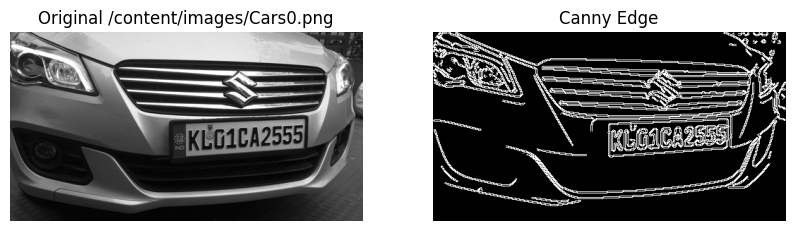

In [131]:
img_path = "/content/images/Cars0.png"

img = io.imread(img_path, as_gray=True)
canny_edge = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f'Original {img_path}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(canny_edge, cmap='gray')
plt.title('Canny Edge')
plt.axis('off')

plt.show()


#HOUGH TRANSFORM

In [132]:
import xml.etree.ElementTree as ET
from skimage.color import rgb2gray
from skimage.io import imread

from skimage.color import rgba2rgb
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [133]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    for member in root.findall('object'):
        plate = member.find('bndbox')
        xmin = int(plate.find('xmin').text)
        xmax = int(plate.find('xmax').text)
        ymin = int(plate.find('ymin').text)
        ymax = int(plate.find('ymax').text)
        return xmin, ymin, xmax, ymax

In [134]:
def create_reference_image(image_path, annotation_path):
    image = imread(image_path)

    if image.shape[2] == 4:
        image = rgba2rgb(image)

    image = rgb2gray(image)

    xmin, ymin, xmax, ymax = parse_annotation(annotation_path)
    reference_image = image[ymin:ymax, xmin:xmax]
    return reference_image


In [135]:
def gradient_orientation(image):

    dx = sobel_x(image)
    dy = sobel_y(image)
    gradient = np.arctan2(dy,dx) * 180 / np.pi

    return gradient

In [136]:
def build_r_table(image, origin):
    edges = canny(image, high=20, low=15)
    gradient = gradient_orientation(edges)

    r_table = defaultdict(list)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            r_table[gradient[i,j]].append((origin[0]-i, origin[1]-j))

    return r_table

In [137]:
def accumulate_gradients(r_table, grayImage):
    edges = canny(grayImage, high=20, low=15)
    gradient = gradient_orientation(edges)

    accumulator = np.zeros(grayImage.shape)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i,j]]:
                k, l = i+r[0], j+r[1]
                if k < accumulator.shape[0] and l < accumulator.shape[1]:
                    accumulator[k, l] += 1

    return accumulator


In [138]:
def hough(img):
    point = (img.shape[0]/2, img.shape[1]/2)
    r_table = build_r_table(img, point)

    def detect_shape(query_image):
        return   accumulate_gradients(r_table, query_image)

    return detect_shape

In [139]:
def max(a, n):
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]


<Figure size 640x480 with 0 Axes>

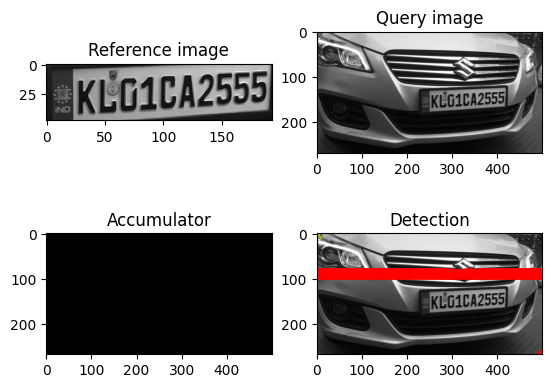

<Figure size 640x480 with 0 Axes>

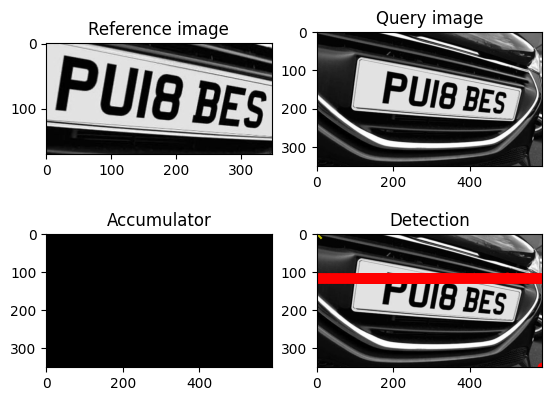

<Figure size 640x480 with 0 Axes>

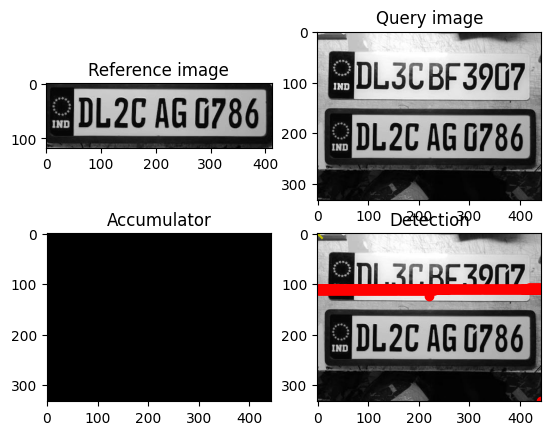

<Figure size 640x480 with 0 Axes>

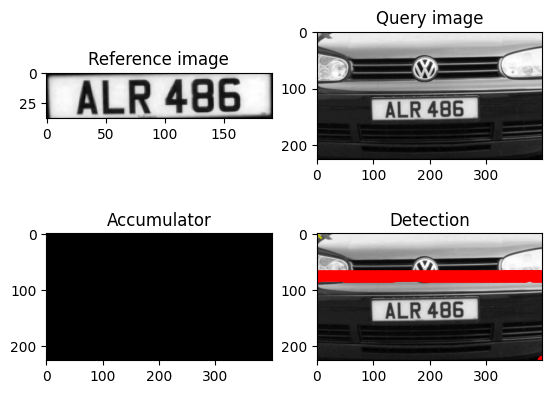

In [143]:
def testhough(gh, reference_image, query):

    query_image = imread(query)
    if query_image.ndim == 3 and query_image.shape[2] == 4:
        query_image = rgba2rgb(query_image)
    if query_image.ndim == 3:
        query_image = rgb2gray(query_image)
    accumulator = gh(query_image)


    plt.clf()
    plt.gray()

    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.title('Reference image')
    plt.imshow(reference_image)

    fig.add_subplot(2,2,2)
    plt.title('Query image')
    plt.imshow(query_image)

    fig.add_subplot(2,2,3)
    plt.title('Accumulator')
    plt.imshow(accumulator)

    fig.add_subplot(2,2,4)
    plt.title('Detection')
    plt.imshow(query_image)


    m = max(accumulator, 1000)
    y_points = [pt[1][0] for pt in m]
    x_points = [pt[1][1] for pt in m]
    plt.scatter(x_points, y_points, marker='o', color='r')


    i,j = np.unravel_index(accumulator.argmax(), accumulator.shape)
    plt.scatter([j], [i], marker='x', color='y')

    plt.show()

    return




def test():


    reference_image_path = "/content/images/Cars0.png"
    annotation_path = "/content/annotations/Cars0.xml"
    reference_image = create_reference_image(reference_image_path, annotation_path)
    detect = hough(reference_image)


    test_image_path = "/content/images/Cars0.png"
    testhough(detect, reference_image, test_image_path)

    ########################################################3

    reference_image_path1 = "/content/images/Cars4.png"
    annotation_path1 = "/content/annotations/Cars4.xml"
    reference_image1 = create_reference_image(reference_image_path1, annotation_path1)
    detect1 = hough(reference_image1)


    test_image_path1 = "/content/images/Cars4.png"
    testhough(detect1, reference_image1, test_image_path1)

    ########################################################3

    reference_image_path2 = "/content/images/Cars44.png"
    annotation_path2 = "/content/annotations/Cars44.xml"
    reference_image2 = create_reference_image(reference_image_path2, annotation_path2)
    detect2 = hough(reference_image2)


    test_image_path2 = "/content/images/Cars44.png"
    testhough(detect2, reference_image2, test_image_path2)

    ########################################################3

    reference_image_path3 = "/content/images/Cars48.png"
    annotation_path3 = "/content/annotations/Cars48.xml"
    reference_image3 = create_reference_image(reference_image_path3, annotation_path3)
    detect3 = hough(reference_image3)


    test_image_path3 = "/content/images/Cars48.png"
    testhough(detect3, reference_image3, test_image_path3)

    ########################################################3

    reference_image_path4 = "/content/images/Cars50.png"
    annotation_path4 = "/content/annotations/Cars50.xml"
    reference_image4 = create_reference_image(reference_image_path4, annotation_path4)
    detect4 = hough(reference_image4)


    test_image_path4 = "/content/images/Cars50.png"
    testhough(detect4, reference_image4, test_image_path4)


test()


<Figure size 640x480 with 0 Axes>

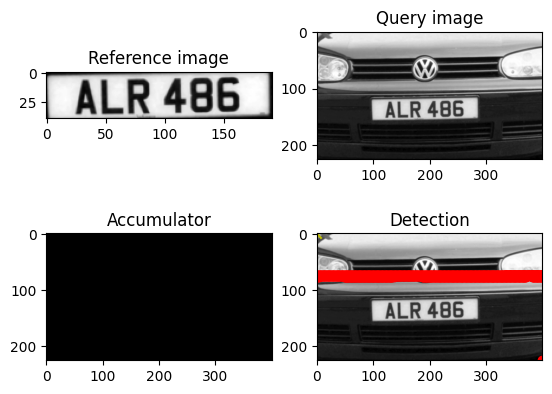

<Figure size 640x480 with 0 Axes>

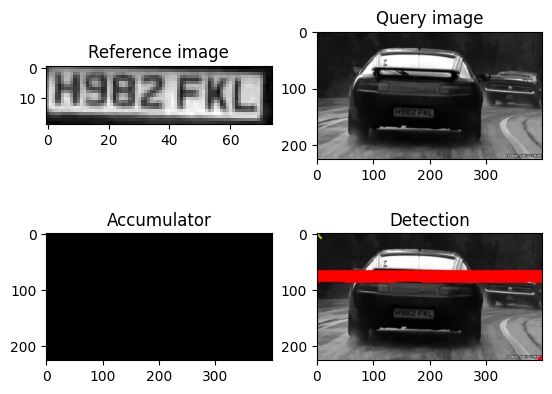

<Figure size 640x480 with 0 Axes>

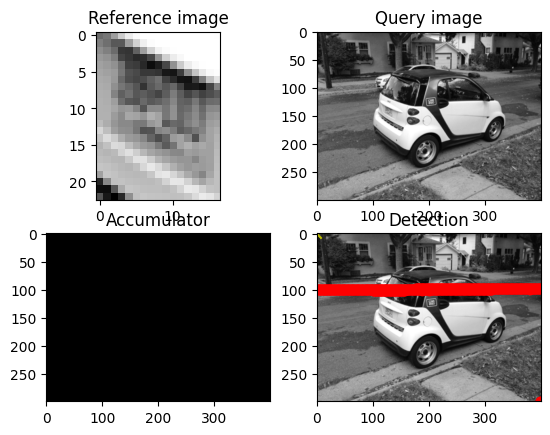

<Figure size 640x480 with 0 Axes>

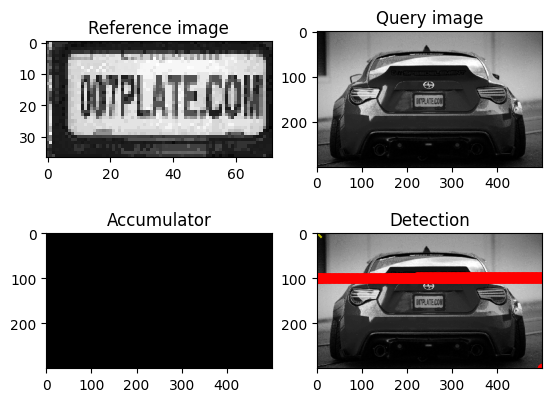

<Figure size 640x480 with 0 Axes>

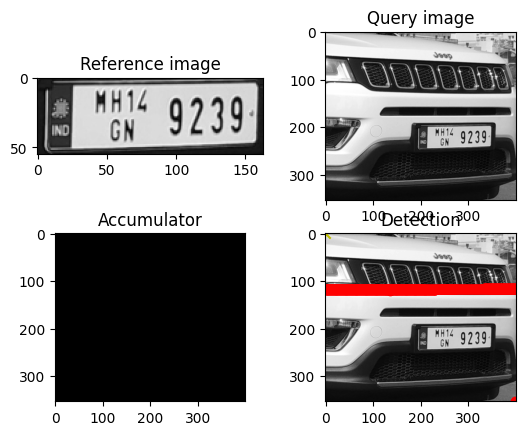

<Figure size 640x480 with 0 Axes>

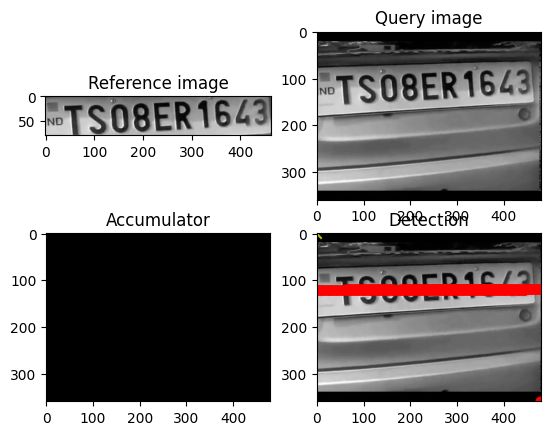

<Figure size 640x480 with 0 Axes>

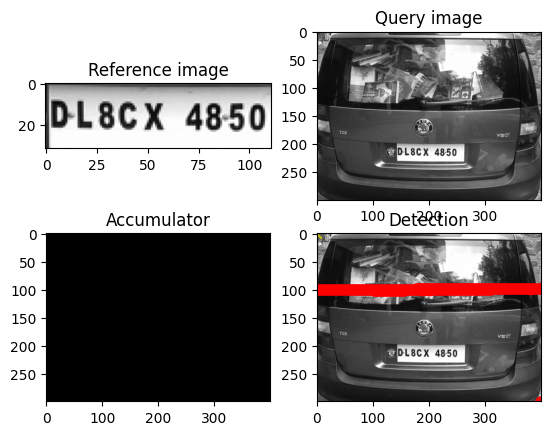

<Figure size 640x480 with 0 Axes>

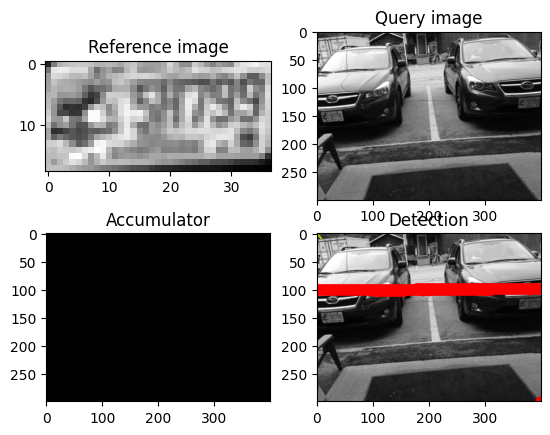

<Figure size 640x480 with 0 Axes>

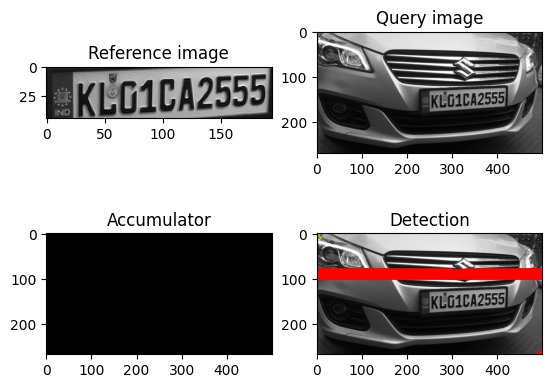

<Figure size 640x480 with 0 Axes>

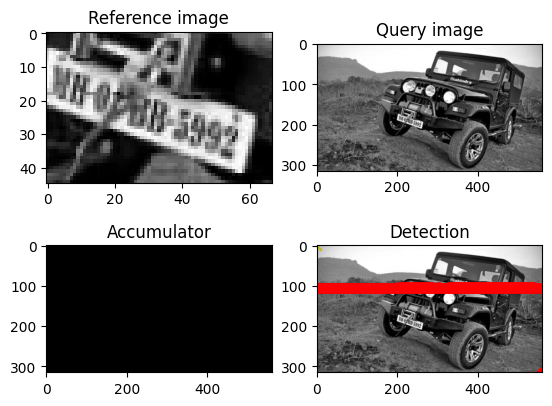

<Figure size 640x480 with 0 Axes>

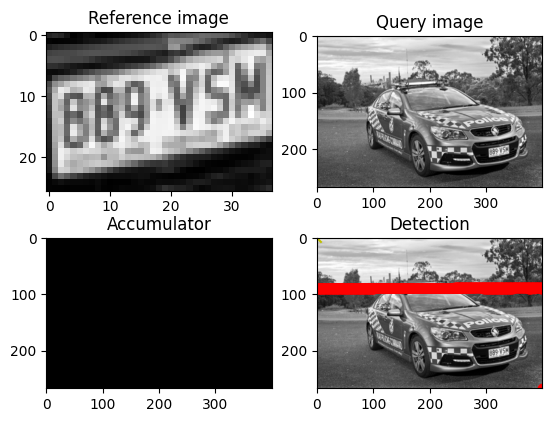

<Figure size 640x480 with 0 Axes>

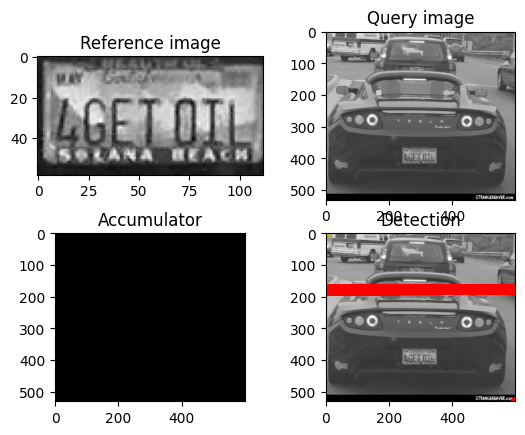

<Figure size 640x480 with 0 Axes>

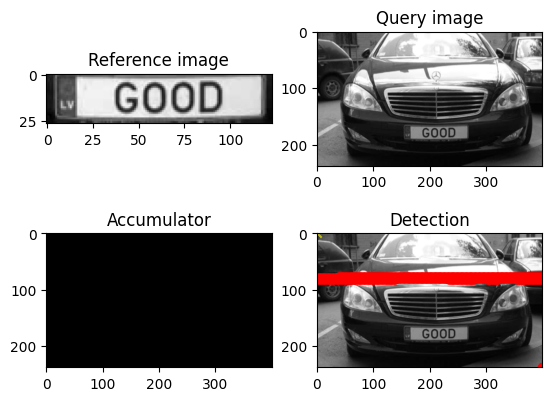

<Figure size 640x480 with 0 Axes>

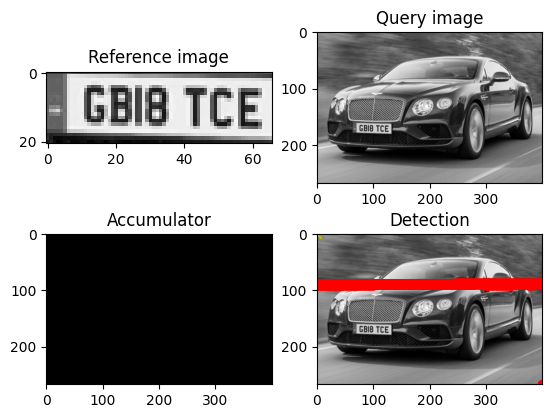

<Figure size 640x480 with 0 Axes>

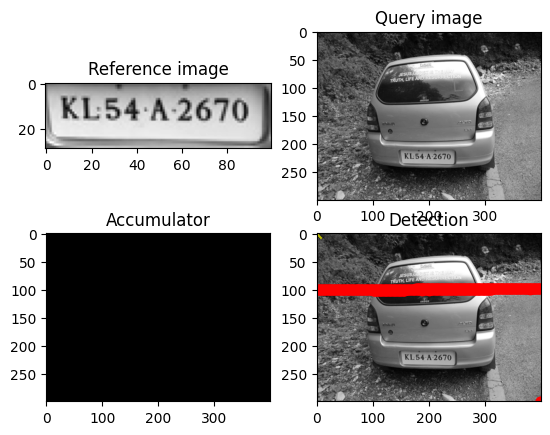

<Figure size 640x480 with 0 Axes>

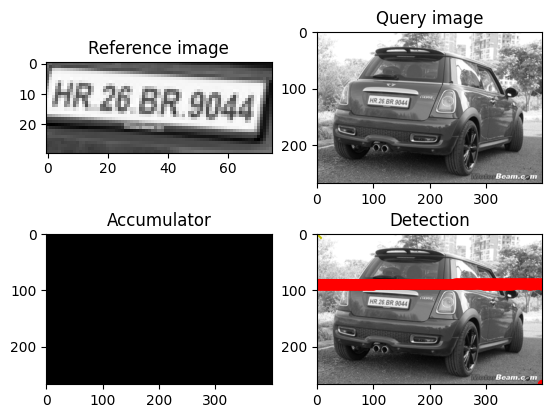

<Figure size 640x480 with 0 Axes>

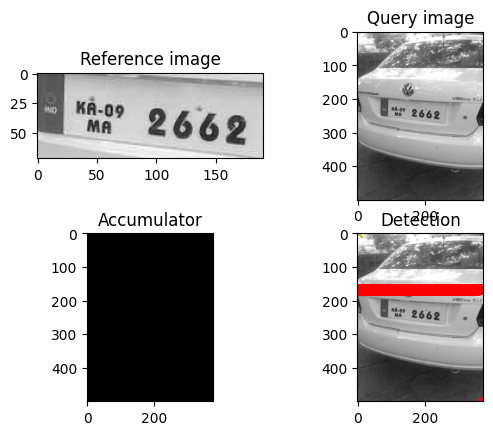

<Figure size 640x480 with 0 Axes>

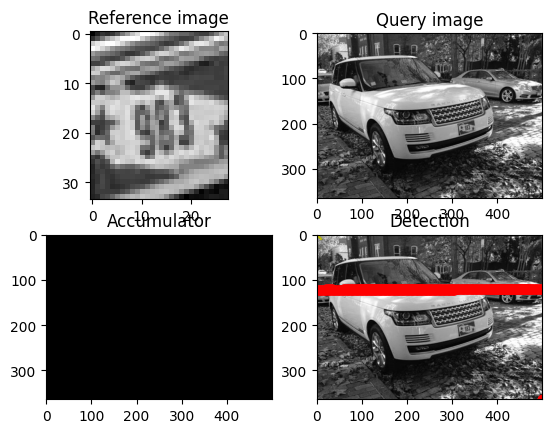

<Figure size 640x480 with 0 Axes>

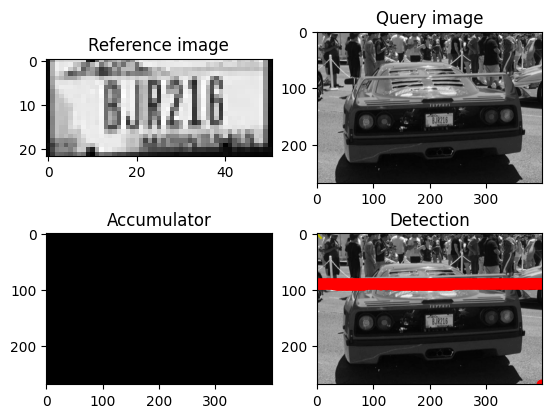

<Figure size 640x480 with 0 Axes>

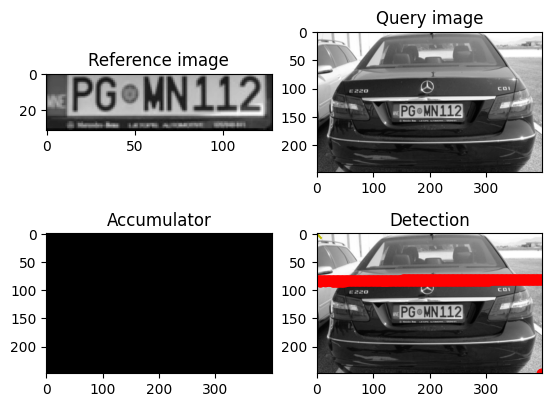

<Figure size 640x480 with 0 Axes>

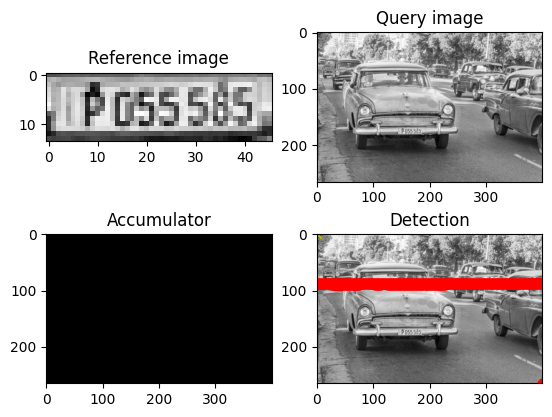

<Figure size 640x480 with 0 Axes>

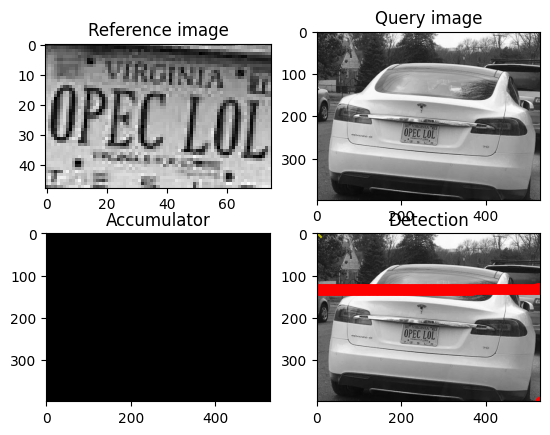

<Figure size 640x480 with 0 Axes>

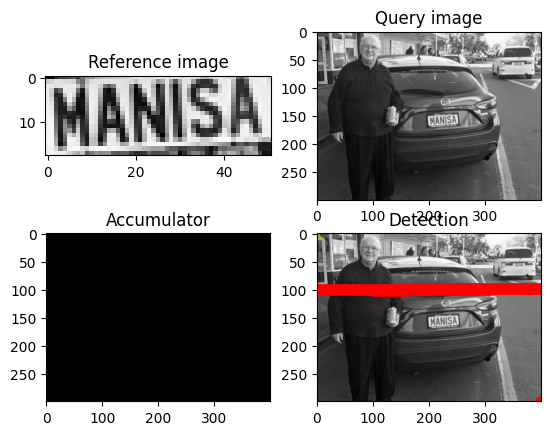

<Figure size 640x480 with 0 Axes>

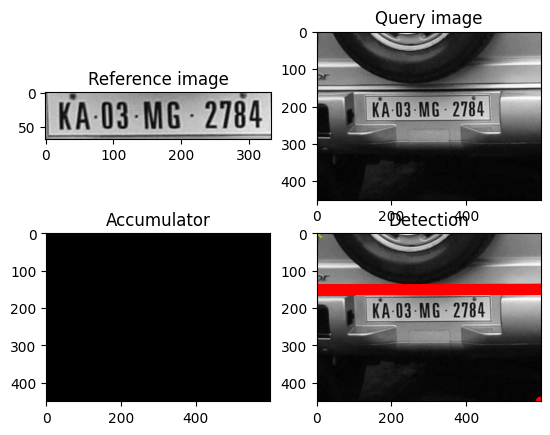

<Figure size 640x480 with 0 Axes>

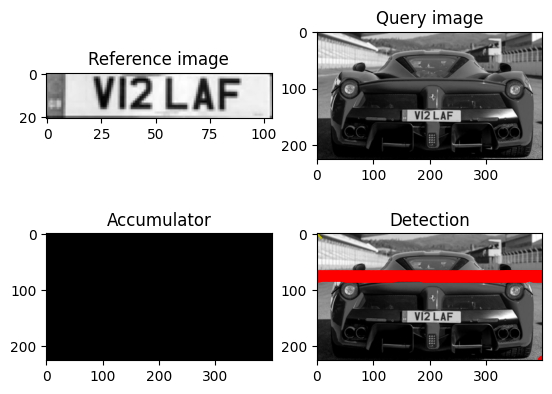

<Figure size 640x480 with 0 Axes>

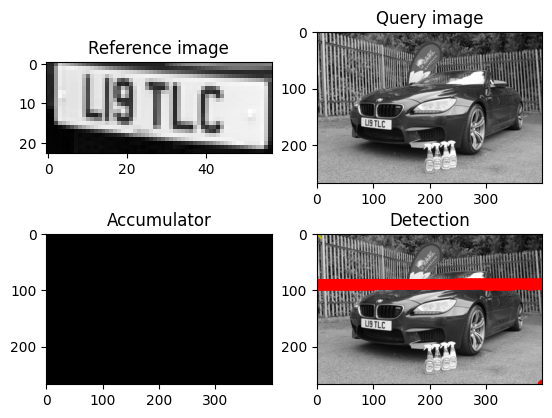

<Figure size 640x480 with 0 Axes>

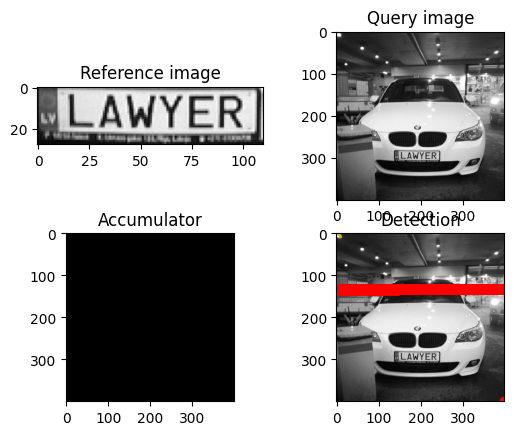

<Figure size 640x480 with 0 Axes>

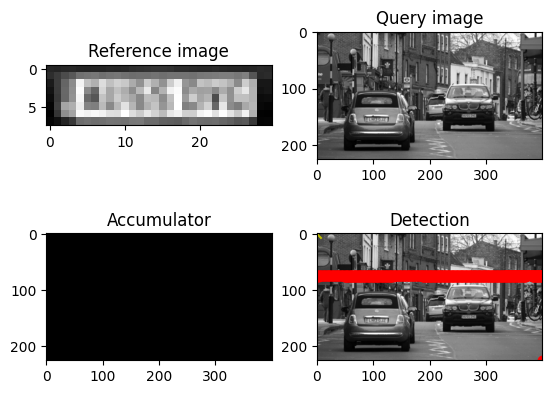

In [ ]:
import os
from skimage.io import imread
from skimage.color import rgb2gray

def test_all(images_dir, annotations_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        annotation_path = os.path.join(annotations_dir, os.path.splitext(image_file)[0] + '.xml')

        if not os.path.exists(annotation_path):
            print(f"Annotation file for {image_file} not found.")
            continue

        reference_image = create_reference_image(image_path, annotation_path)
        detect = hough(reference_image)


        testhough(detect, reference_image, image_path)


images_dir = "/content/images"
annotations_dir = "/content/annotations"


test_all(images_dir, annotations_dir)
